In [1]:
import json
import random
import numpy as np
from matplotlib import pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPooling2D 

from tensorflow.keras.utils import to_categorical

from keras import backend

## Load and parse data

In [2]:
#samples_files = ["2021-09-24-train.samples", "2021-09-24-val.samples", "2021-09-24-test.samples"]
samples_files = ["2021-10-27_train-sitting-standing.samples", "2021-10-27_val-sitting-standing.samples", "2021-10-27_test-sitting-standing.samples"]
#samples_files = ["/content/drive/MyDrive/data/" + f for f in samples_files]
all_samples_by_file = []

for samples_file in samples_files:
    all_samples = []
    with open(samples_file, "r") as file:
        for line in file.readlines():
            sample = json.loads(line)
            all_samples.append(sample)
    
    all_samples_by_file.append(all_samples)

stations = {next(iter(sample.keys())) for sample in all_samples_by_file[0]}

In [3]:
samples_by_station = {}
for station in stations:
    samples_by_station[station] = []
    for f in all_samples_by_file:
        samples_in_file_for_this_station = []
        for sample in f:
            if sample[station]:
                samples_in_file_for_this_station.append(sample[station])
        samples_by_station[station].append(samples_in_file_for_this_station)

In [4]:
selected_station = next(iter(stations))
# selected_station = "..."

samples = samples_by_station[selected_station] # list of datasets

## Prepare data

#### Configuration

In [5]:
subcarriers = len(samples[0][0]["angles"])
discretized_steps = 72  # -> 5° interval
input_shape = (subcarriers, discretized_steps, 1)
val_pct = 0.2
test_pct = 0.2
class_count = max([int(sample["cl"]) for sample in samples[0]])

use_dists = True
data_layers = 2 if use_dists else 1

if samples[0][0]["angles3"] is not None:
    use_multiple_antennas = True
    print("Using 3 TX antennas")
    data_layers *= 3

print(f"Subcarriers {subcarriers}")
print(f"Step Interval:{360/discretized_steps}°, {np.pi * 2.0 / 36} rad")

print(f"Sample size: {subcarriers}x{discretized_steps}x{data_layers}")
print(f"Classes: {class_count}")

Using 3 TX antennas
Subcarriers 55
Step Interval:5.0°, 0.17453292519943295 rad
Sample size: 55x72x6
Classes: 2


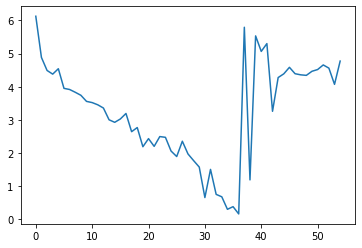

In [6]:
import matplotlib.pyplot as plt

s = []

sample = samples[0][80] 
for subcarrier in range(subcarriers):
    s.append(sample["angles"][subcarrier])

plt.plot(s)

In [7]:
def load_data(samples):    
    shuffled_samples = samples.copy()
    random.shuffle(shuffled_samples)
    
    x_samples = []
    y_samples = []

    for sample in shuffled_samples:
        y_sample = sample["cl"]
        x_sample = np.zeros((subcarriers, discretized_steps, data_layers), dtype="float32")
    
        for subcarrier in range(subcarriers):
            offset_per_antenna = 2 if use_dists else 1
            
            for tx_antenna in range(3 if use_multiple_antennas else 1):
                antenna_suffix = "" if tx_antenna == 0 else str(tx_antenna+1)
                
                angle_value = np.floor(sample["angles" + antenna_suffix][subcarrier] / (2.0*np.pi) * discretized_steps)
                x_sample[subcarrier][int(angle_value)][(tx_antenna * offset_per_antenna) + 0] = 1.0
                
                if use_dists:
                    dist_value = min(len(x_sample[subcarrier])-1, np.floor(sample["dists" + antenna_suffix][subcarrier] / (2000.0) * discretized_steps))
                    x_sample[subcarrier][int(dist_value)][(tx_antenna * offset_per_antenna) + 1] = 1.0
    
        x_sample.reshape((x_sample.shape[0], x_sample.shape[1], data_layers))
    
        x_samples.append(x_sample)
        y_samples.append(y_sample)

    y_samples = to_categorical(np.array(y_samples) - 1, class_count)
    
    return x_samples, y_samples

In [8]:
if len(samples) == 1:
    
    x_samples, y_samples = load_data(samples[0])

    sample_count = len(y_samples)
    test_sample_count = int(test_pct * sample_count)
    val_sample_count = int(val_pct * sample_count)
    train_sample_count = sample_count - test_sample_count - val_sample_count

    print(f"{sample_count} samples, {train_sample_count} train, {val_sample_count} validation, {test_sample_count} test")
    
    x_train = x_samples[0:train_sample_count]
    y_train = y_samples[0:train_sample_count]
    x_val = x_samples[train_sample_count:(train_sample_count+val_sample_count)]
    y_val = y_samples[train_sample_count:(train_sample_count+val_sample_count)]
    x_test = x_samples[(train_sample_count+val_sample_count):sample_count]
    y_test = y_samples[(train_sample_count+val_sample_count):sample_count]

    if backend.image_data_format() == 'channels_first':
        x_train = np.array(x_train).reshape(train_sample_count, 1, subcarriers, discretized_steps)
        x_val = np.array(x_val).reshape(val_sample_count, 1, subcarriers, discretized_steps)
        x_test = np.array(x_test).reshape(test_sample_count, 1, subcarriers, discretized_steps)
    else:
        x_train = np.array(x_train).reshape(train_sample_count, subcarriers, discretized_steps, 1)
        x_val = np.array(x_val).reshape(val_sample_count, subcarriers, discretized_steps, 1)
        x_test = np.array(x_test).reshape(test_sample_count, subcarriers, discretized_steps, 1)
elif len(samples) == 2:
    train_samples = samples[0]
    test_samples = samples[1]
    
    # split validation off of train
    #x_train_val, y_train_val = load_data(train_samples)
    #x_test, y_test = load_data(test_samples)
    
    #train_val_count = len(train_samples)
    #test_sample_count = len(test_samples)
    #val_sample_count = int(val_pct * train_val_count)
    #train_sample_count = train_val_count - val_sample_count
    
    #x_train = x_train_val[0:train_sample_count]
    #y_train = y_train_val[0:train_sample_count]
    #x_val = x_train_val[train_sample_count:(train_sample_count+val_sample_count)]
    #y_val = y_train_val[train_sample_count:(train_sample_count+val_sample_count)]

    # split validation off of test
    x_train, y_train = load_data(train_samples)
    x_test_val, y_test_val = load_data(test_samples)
    
    train_count = len(train_samples)
    test_val_count = len(test_samples)
    val_sample_count = int(0.5 * test_val_count)
    test_sample_count = test_val_count - val_sample_count
    train_sample_count = train_count
    
    x_val = x_test_val[test_sample_count:(test_sample_count+val_sample_count)]
    y_val = y_test_val[test_sample_count:(test_sample_count+val_sample_count)]
    x_test = x_test_val[0:test_sample_count]
    y_test = y_test_val[0:test_sample_count]
    
    print(f"{len(train_samples)+len(test_samples)} samples, {train_sample_count} train, {val_sample_count} validation, {test_sample_count} test")
    
    if backend.image_data_format() == 'channels_first':
        x_train = np.array(x_train).reshape(train_sample_count, data_layers, subcarriers, discretized_steps)
        x_val = np.array(x_val).reshape(val_sample_count, data_layers, subcarriers, discretized_steps)
        x_test = np.array(x_test).reshape(test_sample_count, data_layers, subcarriers, discretized_steps)
    else:
        x_train = np.array(x_train).reshape(train_sample_count, subcarriers, discretized_steps, data_layers)
        x_val = np.array(x_val).reshape(val_sample_count, subcarriers, discretized_steps, data_layers)
        x_test = np.array(x_test).reshape(test_sample_count, subcarriers, discretized_steps, data_layers)
elif len(samples) == 3:
    train_samples = samples[0]
    val_samples = samples[1]
    test_samples = samples[2]
    
    # split validation off of train
    #x_train_val, y_train_val = load_data(train_samples)
    #x_test, y_test = load_data(test_samples)
    
    #train_val_count = len(train_samples)
    #test_sample_count = len(test_samples)
    #val_sample_count = int(val_pct * train_val_count)
    #train_sample_count = train_val_count - val_sample_count
    
    #x_train = x_train_val[0:train_sample_count]
    #y_train = y_train_val[0:train_sample_count]
    #x_val = x_train_val[train_sample_count:(train_sample_count+val_sample_count)]
    #y_val = y_train_val[train_sample_count:(train_sample_count+val_sample_count)]

    # split validation off of test
    x_train, y_train = load_data(train_samples)
    x_val, y_val = load_data(val_samples)
    x_test, y_test = load_data(test_samples)
    
    train_count = len(train_samples)
    val_count = len(val_samples)
    test_count = len(test_samples)
    val_sample_count = val_count
    test_sample_count = test_count
    train_sample_count = train_count
    
    #x_val = x_test_val[test_sample_count:(test_sample_count+val_sample_count)]
    #y_val = y_test_val[test_sample_count:(test_sample_count+val_sample_count)]
    #x_test = x_test_val[0:test_sample_count]
    #y_test = y_test_val[0:test_sample_count]
    
    print(f"{len(train_samples)+len(test_samples)} samples, {train_sample_count} train, {val_sample_count} validation, {test_sample_count} test")
    
    if backend.image_data_format() == 'channels_first':
        x_train = np.array(x_train).reshape(train_sample_count, data_layers, subcarriers, discretized_steps)
        x_val = np.array(x_val).reshape(val_sample_count, data_layers, subcarriers, discretized_steps)
        x_test = np.array(x_test).reshape(test_sample_count, data_layers, subcarriers, discretized_steps)
    else:
        x_train = np.array(x_train).reshape(train_sample_count, subcarriers, discretized_steps, data_layers)
        x_val = np.array(x_val).reshape(val_sample_count, subcarriers, discretized_steps, data_layers)
        x_test = np.array(x_test).reshape(test_sample_count, subcarriers, discretized_steps, data_layers)

600 samples, 400 train, 200 validation, 200 test


In [9]:
#x_train = x_train[0:1]
#x_val = x_val[0:1]
#x_test = x_test[0:1]
#y_train = y_train[0:1]
#y_val = y_val[0:1]
#y_test = y_test[0:1]

## Model

In [19]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
from csi_models import SimpleSequentialModel

model = SimpleSequentialModel(use_batchnorm=False, class_count=class_count, input_shape=input_shape)

In [21]:
model.compile(loss = keras.losses.categorical_crossentropy, 
   optimizer = keras.optimizers.Adadelta(), metrics = ['accuracy'])
model.build(x_train.shape)
model.summary()

Model: "simple_sequential_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            multiple                  4720      
_________________________________________________________________
conv2d_7 (Conv2D)            multiple                  12832     
_________________________________________________________________
conv2d_8 (Conv2D)            multiple                  4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple    

In [22]:
backend.set_value(model.optimizer.learning_rate, 0.02)

history = model.fit(
   x_train, y_train, 
   batch_size = 512, 
   epochs = 60,
   verbose = 1, 
   validation_data = (x_val, y_val)
)

Epoch 1/60
1/1 [==============================] - 1s 1s/step - loss: 0.6781 - accuracy: 0.5825 - val_loss: 0.6835 - val_accuracy: 0.7600
Epoch 2/60
1/1 [==============================] - 0s 223ms/step - loss: 0.6777 - accuracy: 0.5850 - val_loss: 0.6828 - val_accuracy: 0.7750
Epoch 3/60
1/1 [==============================] - 0s 203ms/step - loss: 0.6671 - accuracy: 0.6725 - val_loss: 0.6820 - val_accuracy: 0.7850
Epoch 4/60
1/1 [==============================] - 0s 195ms/step - loss: 0.6736 - accuracy: 0.6125 - val_loss: 0.6813 - val_accuracy: 0.7900
Epoch 5/60
1/1 [==============================] - 0s 202ms/step - loss: 0.6670 - accuracy: 0.6400 - val_loss: 0.6805 - val_accuracy: 0.7950
Epoch 6/60
1/1 [==============================] - 0s 209ms/step - loss: 0.6685 - accuracy: 0.6275 - val_loss: 0.6798 - val_accuracy: 0.8000
Epoch 7/60
1/1 [==============================] - 0s 229ms/step - loss: 0.6629 - accuracy: 0.6875 - val_loss: 0.6790 - val_accuracy: 0.8150
Epoch 8/60
1/1 [=======

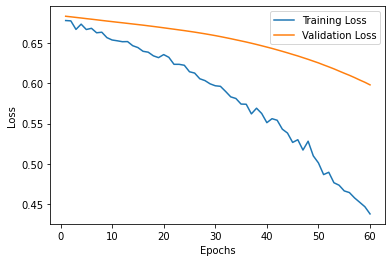

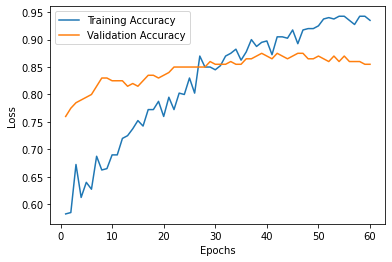

In [23]:
epochs = range(1, len(history.history['loss'])+1)

plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Test

In [24]:
score = model.evaluate(x_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.638148844242096
Test accuracy: 0.7549999952316284


## Predict

In [18]:
pred = model.predict(x_test) 
pred = np.argmax(pred, axis = 1)[:30] 
label = np.argmax(y_test,axis = 1)[:30] 

print(pred) 
print(label)

[0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
[0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1]


In [ ]:
pred = model.predict(x_test)
pred = pred[:10] 
label = y_test[:10] 

print(np.round(pred, decimals = 3)) 
print(label)

[[0.162 0.019 0.73  0.03  0.043 0.01  0.006]
 [0.202 0.098 0.183 0.078 0.119 0.203 0.117]
 [0.061 0.107 0.03  0.284 0.089 0.055 0.374]
 [0.329 0.075 0.034 0.271 0.248 0.017 0.025]
 [0.064 0.371 0.016 0.055 0.077 0.354 0.062]
 [0.063 0.056 0.086 0.577 0.125 0.018 0.074]
 [0.292 0.071 0.169 0.042 0.127 0.24  0.059]
 [0.124 0.071 0.027 0.516 0.187 0.038 0.038]
 [0.047 0.056 0.058 0.39  0.085 0.067 0.297]
 [0.112 0.044 0.041 0.379 0.35  0.03  0.044]]
[[0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]]
